# City Name Generator

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
GPU = False
device = torch.device('cuda' if (torch.cuda.is_available() and GPU) else 'cpu')
device

device(type='cpu')

This project is inspired by Andrej Karpathy’s makemore series, which teaches how to build neural networks from scratch in a really hands-on way. I’m doing this as part of my learning process to better understand how neural networks and natural language processing (NLP) work.

<br>

The main idea is to train a neural network that can generate new city names that sound like real U.S. cities. It won’t be copying existing names, but instead learning patterns from them, like common letter combinations and name structures, to come up with completely new (and hopefully realistic-sounding) ones.

<br>

For the data, I’m using a U.S. cities dataset from SimpleMaps.com. It includes a bunch of information like the city name, state, and county, but for this project I’m only using the city names. That’s all the model needs to learn how cities are usually named in the U.S.

<br>

This project is mostly for practice and experimenting.



This project also includes ideas and techniques from a few well-known research papers:

- Bengio et al. (2003) – for using embeddings to represent characters in a more meaningful way.<br>

- Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift – for adding a BatchNorm layer to help stabilize variance and speed up training.<br>

- Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification – for using Kaiming (He) initialization to improve weight initialization.<br>

- WaveNet: A Generative Model for Raw Audio – for the WaveNet architecture.<br>

## Creating Dataset

To train our neural network, we first need to extract just the city names from the dataset. Then, using a parameter called block_size, we’ll turn these names into training examples for the model.

For example, using the city name Boston" and a block_size of 3, we generate input-output pairs like this:

$$\text{^^^ -> b}$$
$$\text{^^b -> o}$$
$$\text{^bo -> s}$$
$$\text{bos -> t}$$
$$\text{ost -> o}$$
$$\text{sto -> n}$$
$$\text{ton -> ^}$$

where . is a special character indicating either beggining or ending of the name.

<br>

Once all the training examples are created, we split the dataset into:

80% for training

10% for validation (dev)

10% for testing

<br>

Note: All the letters will be made lowercase - this will reduce our vocabulary size

In [4]:
cities = pd.read_csv('uscities.csv')['city'].to_list()
cities = list(set(cities)) # removing duplicates
cities = [city.lower() for city in cities]
chars = sorted(list(set(''.join(cities))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['^'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)

### Example of input/output pairs

In [5]:
X = []
Y = []
block_size = 3
for city in cities[:2]:
    context = [0] * block_size
    for char in city + '^':
        ix = stoi[char]
        X.append(context)
        Y.append(ix)
        print(*[itos[ix] for ix in context], end = '    ')
        print(f'--->    {char}')
        context = context[1:] + [ix]
cities[:2]
random.shuffle(cities)

^ ^ ^    --->    f
^ ^ f    --->    o
^ f o    --->    r
f o r    --->    t
o r t    --->     
r t      --->    s
t   s    --->    e
  s e    --->    n
s e n    --->    e
e n e    --->    c
n e c    --->    a
e c a    --->    ^
^ ^ ^    --->    f
^ ^ f    --->    o
^ f o    --->    r
f o r    --->    t
o r t    --->     
r t      --->    w
t   w    --->    o
  w o    --->    r
w o r    --->    t
o r t    --->    h
r t h    --->    ^


## Making input/output pairs and splits

In [6]:
block_size = 8

def data_split(cities):
    X = []
    Y = []
    for city in cities:
        context = [0] * block_size
        for char in city + '^':
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f'Shape of the input data {X.shape}')
    print(f'Shape of the output data {Y.shape}')
    return X, Y

n1 = int(0.8 * len(cities))
n2 = int(0.9 * len(cities))

X_tr, Y_tr = data_split(cities[:n1])
X_dev, Y_dev = data_split(cities[n1:n2])
X_te, Y_te = data_split(cities[n2:])

Shape of the input data torch.Size([178871, 8])
Shape of the output data torch.Size([178871])
Shape of the input data torch.Size([22042, 8])
Shape of the output data torch.Size([22042])
Shape of the input data torch.Size([22602, 8])
Shape of the output data torch.Size([22602])


## Modules
First let's create from scracth necessary modules (pytorch-like) that are going to be needed for this project.

In [7]:
class Linear():
    def __init__(self, fan_in, fan_out, bias=True, gain=1):
        '''
        Initializes a linear (fully connected) layer.

        Args:
            fan_in (int) - number of input features
            fan_out (int) - number of output featurse
            bias (bool) - if True will include bias term, otherwise will not
            gain (float) - gain of the Kaiming (He) initialization (for ReLu is sqrt(2), for Tanh 5/3)
        '''
        self.weight = torch.randn((fan_in, fan_out), device=device) * gain / (fan_in**0.5)
        self.bias  = torch.zeros(fan_out, device=device) if bias else None

    def __call__(self, x):
        '''
        Performs a forward pass through the Linear layer : y = x @ W (+ b)

        Args:
            x (tensor) - input shape is (batch_size, fan_in)

        Output:
            self.out (tensor) - output shape is (batch_size, fan_out)
        '''
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        '''
        Returns a list of all the learnable parameters of the Linear Layer
        '''
        return [self.weight] + ([] if self.bias is None else [self.bias])

    def reg_params(self):
        '''
        Returns a list of all the learnable parameters that are included in regularization
        '''
        return [self.weight]


class Tanh():
    '''
    Tanh non-linearity layer.
    '''
    def __call__(self, x):
        '''
        Performs a forward pass through the tanh non-linearity layer : y = tanh(x)

        Args:
            x (tensor) - input shape is (batch_size, fan_in)

        Output:
            self.out (tensor) - output shape is (batch_size, fan_in)
        '''
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        '''
        Returns an empty list since Tanh has no learnable parameters.
        '''
        return []

    def reg_params(self):
        '''
        Returns a list of all the learnable parameters that are included in regularization
        '''
        return []


class Embedding():
    """
    Embedding layer for mapping discrete character indices to dense vectors.
    """
    def __init__(self, vocab_size, emb_dim):
        '''
        Initializes the embedding matrix.

        Args:
            vocab_size (int) - number of characters in the vocabulary
            emb_dim (int) - dimension of the embedding vectors
        '''
        self.embedding_table = torch.randn((vocab_size, emb_dim), device=device)

    def __call__(self, x):
        '''
        Performs a forward pass through the Embedding layer, i.e. it is embedding characters into emb_dim dimensional vector.

        Args:
            x (tensor) - input shape is (batch_size, fan_in)

        Output:
            self.out (tensor) - output shape is (batch_size, fan_in, emb_dim)
        '''
        self.out = self.embedding_table[x]
        return self.out

    def parameters(self):
        '''
        Returns a list of all the learnable parameters of the Embedding Layer - only the Embedding matrix
        '''
        return [self.embedding_table]

    def reg_params(self):
        '''
        Returns a list of all the learnable parameters that are included in regularization
        '''
        return [self.embedding_table]


class Flatten():
    '''
    Flatten layer reshapes the input tensor by concatenating groups of characters along the feature dimension.
    '''
    def __init__(self, n):
        '''
        Initializes the Flatten layer.

        Args:
            n (int) - number of characters that are going to be concatenated
        '''
        self.n = n

    def __call__(self, x):
        '''
        Concatenates desired number of characters. If the time (T) dimension becomes 1 it is squeezed out.

        Args:
            x (tensor) - input shape is (B, T, C)
        Output:
            self.out (tensor) - input shape is (B, T//n, C*n) if T//n is 1, the the output shape is (B, C*n)
        '''
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        '''
        Returns an empty list since Flatten has no learnable parameters.
        '''
        return []

    def reg_params(self):
        '''
        Returns a list of all the learnable parameters that are included in regularization
        '''
        return []


class Sequential():
    '''
    A Container class that is going to store all our layers.
    '''
    def __init__(self, layers):
        '''
        Initializes Sequential with all the layers in our network

        Args:
            layers (list): List of layer objects to apply in sequence.
        '''
        self.layers = layers

    def __call__(self, x):
        '''
        Does a forward pass through all the layers inside this container

        Args:
            x (Tensor): Input tensor

        Output:
            Tensor: Output tensor after applying all layers
        '''
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out


    def train(self):
        '''
        Puts all the layers in training mode
        '''
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = True

    def eval(self):
        '''
        Puts all the layers in eval mode
        '''
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = False

    @torch.no_grad()
    def estimate_loss(self, eval_iters, weight_decay):
        '''
       Estimate training and validation loss over a number of iterations.

        Args:
            eval_iters (int): Number of batches to average loss over.

        Output:
            out (dict): Average loss on 'train' and 'dev' splits.
        '''
        out = {}
        self.eval()
        for split in ['train', 'dev']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = {'train': (X_tr, Y_tr),
                        'dev'  : (X_dev, Y_dev),
                        'test' : (X_te, Y_te)}[split]
                ix = torch.randint(high=X.shape[0], size=(eval_iters,))
                Xb, Yb = X[ix].to(device), Y[ix].to(device)
                logits = self(Xb)
                loss = F.cross_entropy(logits, Yb)
                l2 = sum((p**2).sum() for p in self.reg_params())
                loss = loss + weight_decay * l2
                losses[k] = loss.item()
            out[split] = losses.mean()
        self.train()                         # Set model back to training mode
        return out

    def fit(self, max_steps, batch_size, lr, eval_interval=500, eval_iters=128, weight_decay = 1e-4, verbose=True):
        '''
        Train the model using gradient descent.

        Args:
            max_steps (int): Total number of training iterations.
            batch_size (int): Number of examples per training batch.
            lr (float): Initial learning rate.
            eval_interval (int): Evaluation interval in steps.
            eval_iters (int): Number of steps for loss estimation.
            weight_decay (bool) : used for regularization
            verbose (bool): Whether to print progress.
        '''
        self.train()
        self.train_losses = []
        self.val_losses = []
        self.epochs = []
        for i in range(max_steps):

            if i % eval_interval == 0:
                losses = self.estimate_loss(eval_iters, weight_decay)
                self.train_losses.append(losses['train'].item())
                self.val_losses.append(losses['dev'].item())
                self.epochs.append(i)

            ix = torch.randint(high=X_tr.shape[0], size=(batch_size,))
            Xb, Yb = X_tr[ix].to(device), Y_tr[ix].to(device)

            logits = self(Xb)
            loss = F.cross_entropy(logits, Yb)
            l2 = sum((p**2).sum() for p in self.reg_params())
            loss = loss + weight_decay * l2
            for p in self.parameters():
                p.grad = None

            if i == int(0.5*max_steps):
                lr /= 10
            if i == int(0.8*max_steps):
                lr /= 5

            loss.backward()
            for p in self.parameters():
                p.data -= lr*p.grad

            if verbose and i % 10000 == 0:
                print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    def plot_loss(self):
        '''
        Plots the estimated loss over the epochs
        '''
        fig, ax = plt.subplots(figsize=(10, 6))

        ax.plot(self.epochs, self.train_losses, label='Training Loss', color='tab:blue', linewidth=2)
        ax.plot(self.epochs, self.val_losses, label='Validation Loss', color='tab:orange', linewidth=2)

        ax.set_xlabel('Iterations', fontsize=14)
        ax.set_ylabel('Loss', fontsize=14)
        ax.set_title('Training vs Validation Loss', fontsize=16)

        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.xaxis.set_major_locator(plt.MaxNLocator(10))

        for label in ax.get_xticklabels():
            label.set_rotation(45)

        ax.grid(True, linestyle='--', alpha=0.4)
        ax.legend(fontsize=12)

        plt.tight_layout()
        plt.show()


    def calculate_loss(self, split, weight_decay=1e-4):
        """
        Compute loss for a specified dataset split.

        Args:
            split (str): One of 'train', 'dev', or 'test'.

        Output:
            (float): Loss value on the specified split.
        """
        self.eval()
        X, Y = {'train': (X_tr, Y_tr),
                'dev'  : (X_dev, Y_dev),
                'test' : (X_te, Y_te)}[split]
        X = X.to(device)
        Y = Y.to(device)
        logits = self(X)
        loss = F.cross_entropy(logits, Y)
        l2 = sum((p**2).sum() for p in self.reg_params())
        loss = loss + weight_decay * l2
        self.train()
        return loss.item()

    def no_reg_loss(self, split):
        self.eval()
        X, Y = {'train': (X_tr, Y_tr),
                'dev'  : (X_dev, Y_dev),
                'test' : (X_te, Y_te)}[split]
        X = X.to(device)
        Y = Y.to(device)
        logits = self(X)
        loss = F.cross_entropy(logits, Y)
        self.train()
        print(f'{split} loss (without regularization loss): {loss:.4f}')

    def parameters(self):
        '''
        Returns all the learnable parameters of the layers that are soted inside
        '''
        return [p for layer in self.layers for p in layer.parameters()]

    def reg_params(self):
        '''
        Returns a list of all the learnable parameters that are included in regularization
        '''
        return [p for layer in self.layers for p in layer.reg_params()]

    def to(self, device):
        '''
        Puts all the parameters of the model on the chosen device
        '''
        for p in self.parameters():
            p.data = p.data.to(device)

    def generate(self, n):
        '''
        Generates new city names

        Args:
            n (int) - number of city names to be generated
        '''
        self.eval()
        for _ in range(n):

            out = []
            context = [0] * block_size
            while True:
                logits = self(torch.tensor([context]))
                probs = F.softmax(logits, dim=1)
                ix = torch.multinomial(probs, num_samples=1).item()
                context = context[1:] + [ix]
                out.append(ix)
                if ix == 0:
                    break
            print(''.join(itos[i] for i in out)) # decode and print the generated word
        self.train()

class BatchNorm():
    """
    BatchNorm layer that normalizes inputs to stabilize and accelerate training.
    Supports both 2D and 3D tensors.
    """
    def __init__(self, dim, momentum = 0.1, eps = 1e-8):
        '''
        Initializes BatchNorm layer.

        Args:
            dim (int): Number of features (usually the size of the last dimension).
            momentum (float) - used to calculate running mean and variance
            eps (float) - small positive number that helps to avoid division by zero when narmalizing by standard deviation

        Atributes:
            training (bool) - indicates wheter the model is in training state or in eval state
            gamma (float) - BatchNorm layer parameter used to scale the normalized inputs
            beta (float) - BatchNorm layer parameter used to shift the normalized inputs
            running_mean (float) - stores calculated mean
            running_var (float) - stores calculated var
        '''
        self.momentum = momentum
        self.eps = eps
        self.training = True
        self.gamma = torch.ones(dim, device=device)
        self.beta = torch.zeros(dim, device=device)
        self.running_mean = torch.zeros(dim, device=device)
        self.running_var = torch.ones(dim, device=device)

    def __call__(self, x):
        """
        Applies batch normalization to input tensor as defined in the paper.

        Args:
            x (Tensor): Input tensor of shape (B, C) or (B, T, C)

        Returns:
            self.out (tensor): Normalized and scaled input
        """
        if self.training:
            if x.ndim == 3:
                dim = (0, 1)
            elif x.ndim == 2:
                dim = 0
            x_mean = x.mean(dim=dim, keepdim=True)
            x_var = x.var(dim=dim, keepdim=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var

        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*x_mean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum*x_var

        self.out = self.gamma * ((x-x_mean)/torch.sqrt(x_var+self.eps)) + self.beta
        return self.out

    def parameters(self):
        '''
        Return all the learnable parameters of the BatchNOrm layer
        '''
        return [self.gamma, self.beta]

    def reg_params(self):
        '''
        Returns a list of all the learnable parameters that are included in regularization
        '''
        return [self.gamma]

In [8]:
def train_and_eval(model, max_steps, batch_size, lr, wd=1e-4):
    model.fit(max_steps, batch_size, lr, weight_decay=wd)
    model.plot_loss()
    tl = model.calculate_loss('train', weight_decay=wd)
    vl = model.calculate_loss('dev', weight_decay=wd)
    print(f'Train loss : {tl:.4f}')
    print(f'Dev loss : {vl:.4f}')
    model.no_reg_loss('train')
    model.no_reg_loss('dev')

In [9]:
def find_learning_rate(lre, batch_size, model, weight_decay):
    lrs = 10**lre
    losses = []

    for lr in lrs:

        ix = torch.randint(high=X_tr.shape[0], size=(batch_size,))
        Xb, Yb = X_tr[ix], Y_tr[ix]

        logits = model(Xb)
        loss = F.cross_entropy(logits, Yb)
        l2 = sum((p**2).sum() for p in model.reg_params())
        loss = loss + weight_decay * l2
        losses.append(loss.log10().item())

        for p in model.parameters():
            p.grad = None

        loss.backward()
        for p in model.parameters():
            p.data -= lr*p.grad
    plt.figure()
    plt.plot(lre,losses)
    plt.xlabel('log10(learning_rate)')
    plt.ylabel('loss')

## Making Model

Model will follow WaveNet architecute, concatenating 2 by 2 characters until we concatenate all block_size characters into a single sequence. We will be making multiple models, train them and then if needed make more adjustments and then choose the model that fits our data the best.


In [25]:
emb_dim = 5
n_hidden = 50
model1 = Sequential([
    Embedding(vocab_size, emb_dim),
    Flatten(2), Linear(2*emb_dim, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, gain=0.05)
])

model1.to(device)

for p in model1.parameters():
      p.requires_grad = True

In [26]:
emb_dim = 10
n_hidden = 50
model2 = Sequential([
    Embedding(vocab_size, emb_dim),
    Flatten(2), Linear(2*emb_dim, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, gain=0.1)
])

model2.to(device)

for p in model2.parameters():
      p.requires_grad = True

In [27]:
emb_dim = 15
n_hidden = 50
model3 = Sequential([
    Embedding(vocab_size, emb_dim),
    Flatten(2), Linear(2*emb_dim, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, gain=0.1)
])

model3.to(device)

for p in model3.parameters():
      p.requires_grad = True

In [28]:
emb_dim = 10
n_hidden = 20
model4 = Sequential([
    Embedding(vocab_size, emb_dim),
    Flatten(2), Linear(2*emb_dim, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, gain=0.1)
])

model4.to(device)

for p in model4.parameters():
      p.requires_grad = True

In [29]:
emb_dim = 10
n_hidden = 20
model5 = Sequential([
    Embedding(vocab_size, emb_dim),
    Flatten(2), Linear(2*emb_dim, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, 2*n_hidden, gain=5/3, bias=False), BatchNorm(2*n_hidden), Tanh(),
    Flatten(2), Linear(4*n_hidden, 4*n_hidden, gain=5/3, bias=False), BatchNorm(4*n_hidden), Tanh(),
    Linear(4*n_hidden, vocab_size, gain=0.1)
])

model5.to(device)

for p in model5.parameters():
      p.requires_grad = True

In [30]:
emb_dim = 10
n_hidden = 30
model6 = Sequential([
    Embedding(vocab_size, emb_dim),
    Flatten(2), Linear(2*emb_dim, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, 2*n_hidden, gain=5/3, bias=False), BatchNorm(2*n_hidden), Tanh(),
    Flatten(2), Linear(4*n_hidden, 4*n_hidden, gain=5/3, bias=False), BatchNorm(4*n_hidden), Tanh(),
    Linear(4*n_hidden, vocab_size, gain=0.1)
])

model6.to(device)

for p in model6.parameters():
      p.requires_grad = True

In [31]:
emb_dim = 10
n_hidden = 30
model7 = Sequential([
    Embedding(vocab_size, emb_dim),
    Flatten(2), Linear(2*emb_dim, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, 2*n_hidden, gain=5/3, bias=False), BatchNorm(2*n_hidden), Tanh(),
    Flatten(2), Linear(4*n_hidden, 4*n_hidden, gain=5/3, bias=False), BatchNorm(4*n_hidden), Tanh(),
    Linear(4*n_hidden, 2*n_hidden, gain=5/3, bias=False), BatchNorm(2*n_hidden), Tanh(),
    Linear(2*n_hidden, vocab_size, gain=0.1)
])

model7.to(device)

for p in model7.parameters():
      p.requires_grad = True

In [32]:
emb_dim = 20
n_hidden = 100
model8 = Sequential([
    Embedding(vocab_size, emb_dim),
    Flatten(2), Linear(2*emb_dim, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, gain=0.1)
])

model8.to(device)

for p in model8.parameters():
      p.requires_grad = True

In [33]:
emb_dim = 10
n_hidden = 20
model9 = Sequential([
    Embedding(vocab_size, emb_dim),
    Flatten(2), Linear(2*emb_dim, n_hidden, gain=5/3, bias=False), BatchNorm(n_hidden), Tanh(),
    Flatten(2), Linear(2*n_hidden, 2*n_hidden, gain=5/3, bias=False), BatchNorm(2*n_hidden), Tanh(),
    Flatten(2), Linear(4*n_hidden, 4*n_hidden, gain=5/3, bias=False), BatchNorm(4*n_hidden), Tanh(),
    Linear(4*n_hidden, 2*n_hidden, gain=5/3, bias=False), BatchNorm(2*n_hidden), Tanh(),
    Linear(2*n_hidden, vocab_size, gain=0.1)
])

model9.to(device)

for p in model9.parameters():
      p.requires_grad = True

In [34]:
model11 = Sequential([
    Embedding(vocab_size, 10),
    Flatten(2), Linear(2*10, 80, gain=5/3, bias=False), BatchNorm(80), Tanh(),    # Expansion
    Flatten(2), Linear(2*80, 30, gain=5/3, bias=False), BatchNorm(30), Tanh(),    # Compression
    Flatten(2), Linear(2*30, 80, gain=5/3, bias=False), BatchNorm(80), Tanh(),    # Expansion
    Linear(80, vocab_size, gain=0.1)
])

model11.to(device)

for p in model11.parameters():
      p.requires_grad = True

In [35]:
model12 = Sequential([
    Embedding(vocab_size, 8),
    Flatten(2), Linear(2*8, 32, gain=5/3, bias=False), BatchNorm(32), Tanh(),
    Flatten(2), Linear(2*32, 64, gain=5/3, bias=False), BatchNorm(64), Tanh(),
    Flatten(2), Linear(2*64, 96, gain=5/3, bias=False), BatchNorm(96), Tanh(),
    Linear(96, vocab_size, gain=0.1)
])

model12.to(device)

for p in model12.parameters():
      p.requires_grad = True

In [36]:
model13 = Sequential([
    Embedding(vocab_size, 16),
    Flatten(2), Linear(2*16, 128, gain=5/3, bias=False), BatchNorm(128), Tanh(),
    Flatten(2), Linear(2*128, 32, gain=5/3, bias=False), BatchNorm(32), Tanh(),
    Flatten(2), Linear(2*32, 64, gain=5/3, bias=False), BatchNorm(64), Tanh(),
    Linear(64, vocab_size, gain=0.1)
])

model13.to(device)

for p in model13.parameters():
      p.requires_grad = True

#### Training models

In [37]:
lr = 0.3
batch_size = 256
max_steps = 300000
wd = 1e-4

MODEL 1:
      0/ 300000: 3.8611
  10000/ 300000: 2.0528
  20000/ 300000: 2.2457
  30000/ 300000: 2.0508
  40000/ 300000: 2.2339
  50000/ 300000: 1.8876
  60000/ 300000: 2.0323
  70000/ 300000: 2.0141
  80000/ 300000: 2.0461
  90000/ 300000: 2.0324
 100000/ 300000: 1.9474
 110000/ 300000: 1.9736
 120000/ 300000: 2.2422
 130000/ 300000: 2.1768
 140000/ 300000: 2.2828
 150000/ 300000: 2.3164
 160000/ 300000: 2.1518
 170000/ 300000: 1.9460
 180000/ 300000: 1.8819
 190000/ 300000: 1.9999
 200000/ 300000: 1.7667
 210000/ 300000: 2.0989
 220000/ 300000: 1.8046
 230000/ 300000: 1.7913
 240000/ 300000: 2.1610
 250000/ 300000: 1.6232
 260000/ 300000: 1.7766
 270000/ 300000: 1.8239
 280000/ 300000: 1.8790
 290000/ 300000: 1.8836


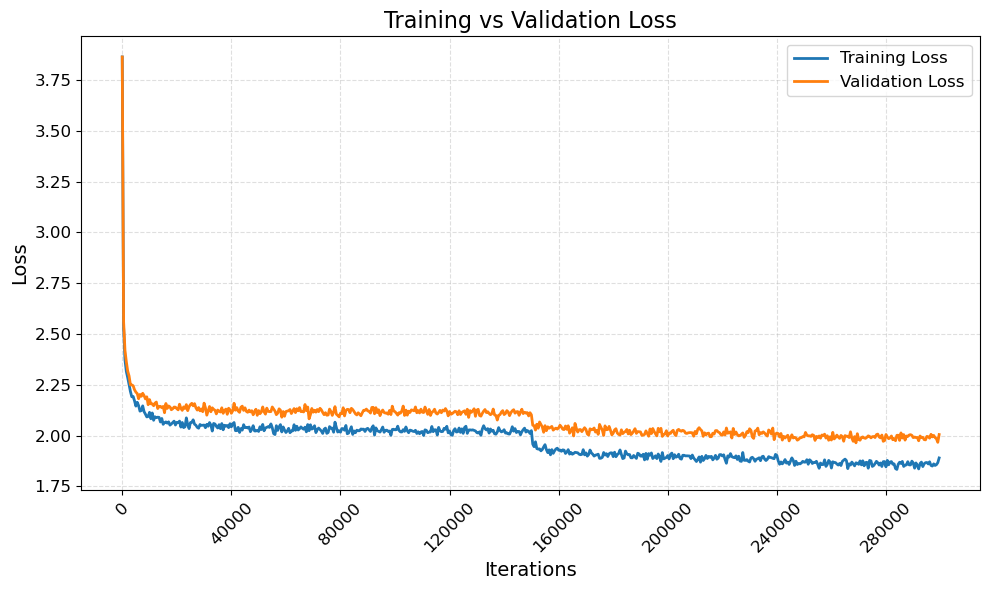

Train loss : 1.8595
Dev loss : 1.9896
train loss (without regularization loss): 1.7745
dev loss (without regularization loss): 1.9046
-----------------------------------------
MODEL 2:
      0/ 300000: 3.8950
  10000/ 300000: 1.9969
  20000/ 300000: 2.1440
  30000/ 300000: 2.1449
  40000/ 300000: 2.1291
  50000/ 300000: 2.0830
  60000/ 300000: 2.0795
  70000/ 300000: 2.0799
  80000/ 300000: 1.8576
  90000/ 300000: 2.2044
 100000/ 300000: 2.1937
 110000/ 300000: 1.9193
 120000/ 300000: 2.0875
 130000/ 300000: 2.1202
 140000/ 300000: 1.8125
 150000/ 300000: 2.1497
 160000/ 300000: 1.7597
 170000/ 300000: 2.1270
 180000/ 300000: 1.6799
 190000/ 300000: 1.9270
 200000/ 300000: 1.9597
 210000/ 300000: 1.9328
 220000/ 300000: 1.8093
 230000/ 300000: 1.9668
 240000/ 300000: 1.8464
 250000/ 300000: 1.7965
 260000/ 300000: 1.7721
 270000/ 300000: 1.7173
 280000/ 300000: 1.9227
 290000/ 300000: 1.9515


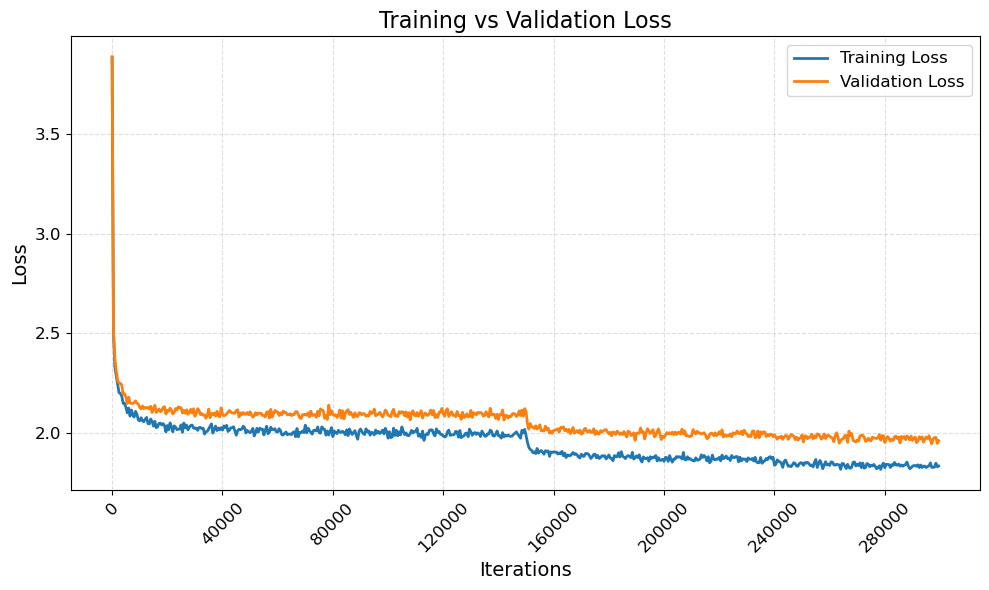

Train loss : 1.8357
Dev loss : 1.9738
train loss (without regularization loss): 1.7520
dev loss (without regularization loss): 1.8902
-----------------------------------------
MODEL 3:
      0/ 300000: 3.9083
  10000/ 300000: 2.1522
  20000/ 300000: 2.0631
  30000/ 300000: 1.8932
  40000/ 300000: 2.1190
  50000/ 300000: 2.0761
  60000/ 300000: 2.0985
  70000/ 300000: 1.8480
  80000/ 300000: 1.7902
  90000/ 300000: 1.9180
 100000/ 300000: 1.9156
 110000/ 300000: 1.9624
 120000/ 300000: 2.1653
 130000/ 300000: 1.8615
 140000/ 300000: 1.9424
 150000/ 300000: 2.0981
 160000/ 300000: 1.9204
 170000/ 300000: 1.9887
 180000/ 300000: 2.0002
 190000/ 300000: 1.9496
 200000/ 300000: 1.8141
 210000/ 300000: 2.1574
 220000/ 300000: 2.0436
 230000/ 300000: 1.9169
 240000/ 300000: 1.6368
 250000/ 300000: 1.7186
 260000/ 300000: 1.7288
 270000/ 300000: 2.1163
 280000/ 300000: 1.8445
 290000/ 300000: 1.7772


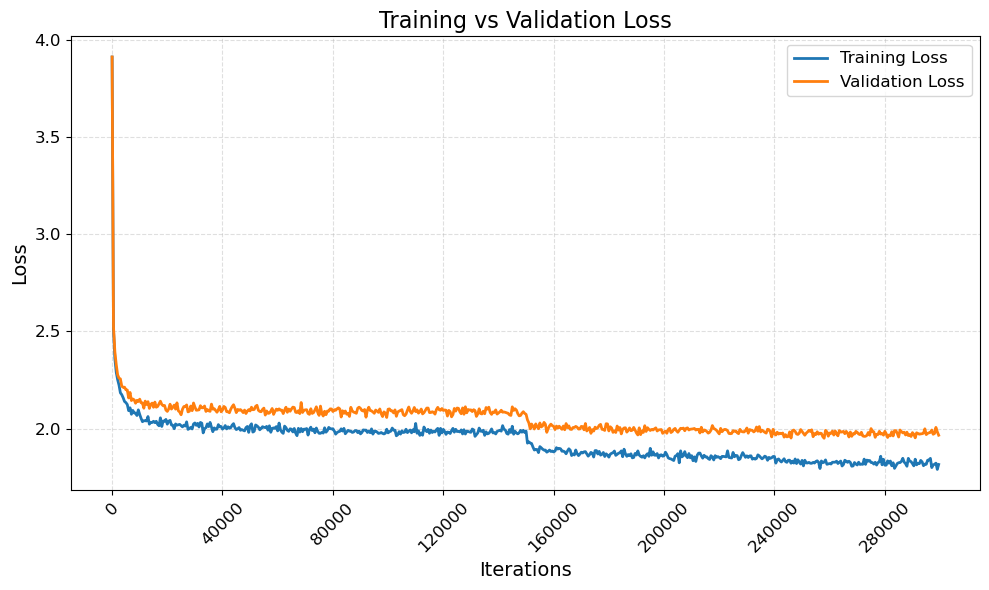

Train loss : 1.8225
Dev loss : 1.9693
train loss (without regularization loss): 1.7395
dev loss (without regularization loss): 1.8863
-----------------------------------------
MODEL 4:
      0/ 300000: 3.8624
  10000/ 300000: 2.2197
  20000/ 300000: 2.2717
  30000/ 300000: 2.1806
  40000/ 300000: 1.9760
  50000/ 300000: 2.3209
  60000/ 300000: 2.1797
  70000/ 300000: 2.3370
  80000/ 300000: 2.2229
  90000/ 300000: 2.2184
 100000/ 300000: 2.2761
 110000/ 300000: 2.1140
 120000/ 300000: 2.1408
 130000/ 300000: 2.3721
 140000/ 300000: 2.1829
 150000/ 300000: 2.1809
 160000/ 300000: 2.1440
 170000/ 300000: 2.3050
 180000/ 300000: 2.1598
 190000/ 300000: 2.0181
 200000/ 300000: 2.0329
 210000/ 300000: 2.1873
 220000/ 300000: 2.2941
 230000/ 300000: 2.1150
 240000/ 300000: 2.2162
 250000/ 300000: 2.0217
 260000/ 300000: 1.9965
 270000/ 300000: 2.0983
 280000/ 300000: 2.0487
 290000/ 300000: 2.1173


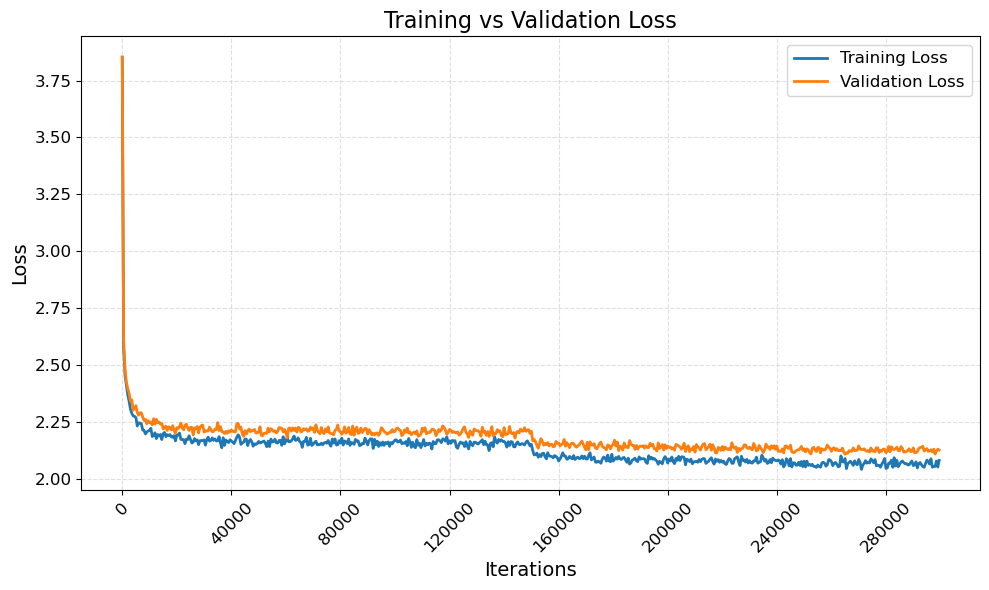

Train loss : 2.0634
Dev loss : 2.1234
train loss (without regularization loss): 2.0130
dev loss (without regularization loss): 2.0730
-----------------------------------------
MODEL 5:
      0/ 300000: 3.8774
  10000/ 300000: 2.1162
  20000/ 300000: 2.0038
  30000/ 300000: 2.0883
  40000/ 300000: 1.9865
  50000/ 300000: 1.9074
  60000/ 300000: 1.9264
  70000/ 300000: 2.0798
  80000/ 300000: 2.2240
  90000/ 300000: 2.0521
 100000/ 300000: 2.0982
 110000/ 300000: 1.9751
 120000/ 300000: 1.9312
 130000/ 300000: 2.1378
 140000/ 300000: 1.8551
 150000/ 300000: 1.9489
 160000/ 300000: 2.0119
 170000/ 300000: 2.0172
 180000/ 300000: 2.0600
 190000/ 300000: 1.9065
 200000/ 300000: 2.1814
 210000/ 300000: 1.9993
 220000/ 300000: 1.8655
 230000/ 300000: 2.0793
 240000/ 300000: 1.8762
 250000/ 300000: 2.0635
 260000/ 300000: 1.8087
 270000/ 300000: 1.8932
 280000/ 300000: 1.8688
 290000/ 300000: 1.8566


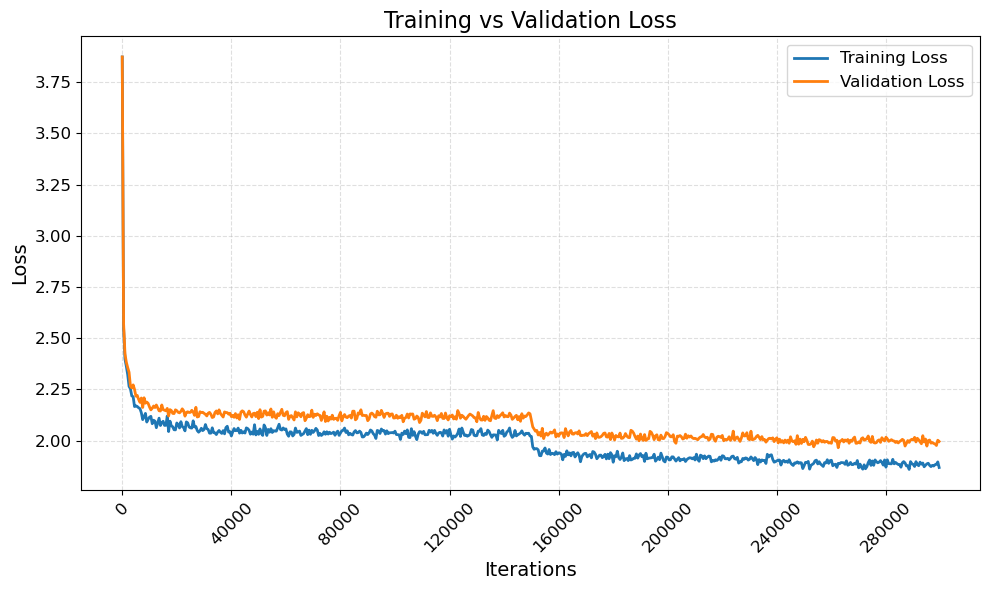

Train loss : 1.8862
Dev loss : 1.9964
train loss (without regularization loss): 1.8043
dev loss (without regularization loss): 1.9146
-----------------------------------------
MODEL 6:
      0/ 300000: 4.1486
  10000/ 300000: 2.1396
  20000/ 300000: 2.1751
  30000/ 300000: 2.2290
  40000/ 300000: 2.3335
  50000/ 300000: 2.0989
  60000/ 300000: 2.0319
  70000/ 300000: 2.2649
  80000/ 300000: 1.9828
  90000/ 300000: 2.2574
 100000/ 300000: 2.0260
 110000/ 300000: 2.2479
 120000/ 300000: 2.1206
 130000/ 300000: 2.2106
 140000/ 300000: 2.0759
 150000/ 300000: 1.9259
 160000/ 300000: 1.8277
 170000/ 300000: 2.1437
 180000/ 300000: 1.7764
 190000/ 300000: 1.8174
 200000/ 300000: 1.8090
 210000/ 300000: 1.9808
 220000/ 300000: 1.7492
 230000/ 300000: 1.8057
 240000/ 300000: 1.8327
 250000/ 300000: 1.8168
 260000/ 300000: 1.7552
 270000/ 300000: 1.9245
 280000/ 300000: 1.8694
 290000/ 300000: 1.9360


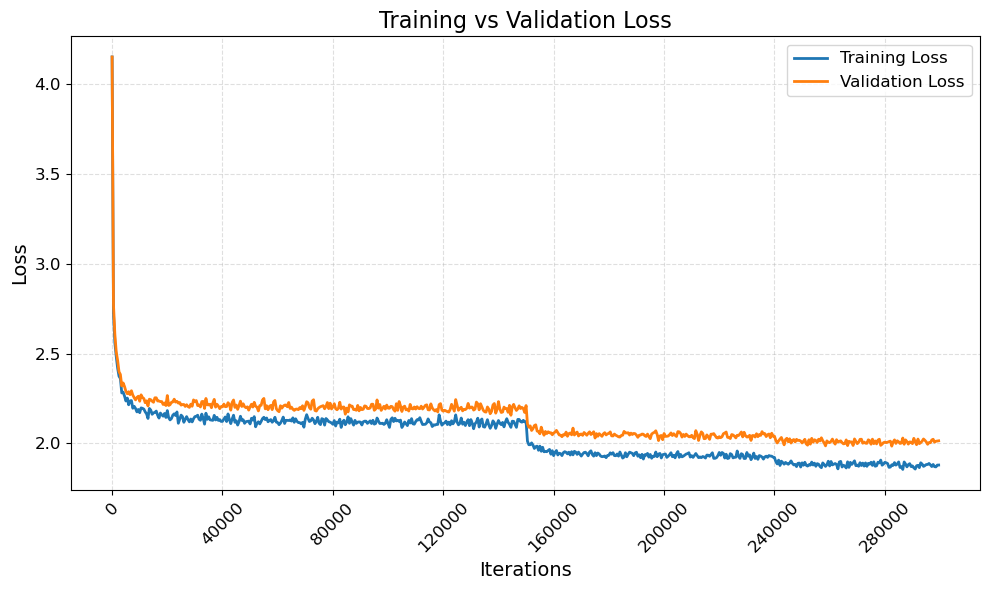

Train loss : 1.8758
Dev loss : 2.0090
train loss (without regularization loss): 1.7388
dev loss (without regularization loss): 1.8720
-----------------------------------------
MODEL 7:
      0/ 300000: 4.2245
  10000/ 300000: 2.2344
  20000/ 300000: 2.0845
  30000/ 300000: 2.0254
  40000/ 300000: 2.2299
  50000/ 300000: 2.2161
  60000/ 300000: 1.9757
  70000/ 300000: 2.1251
  80000/ 300000: 2.0705
  90000/ 300000: 2.1200
 100000/ 300000: 1.9610
 110000/ 300000: 1.9433
 120000/ 300000: 1.9974
 130000/ 300000: 2.0877
 140000/ 300000: 1.9700
 150000/ 300000: 2.1066
 160000/ 300000: 1.7265
 170000/ 300000: 1.9379
 180000/ 300000: 1.9202
 190000/ 300000: 1.8283
 200000/ 300000: 1.8995
 210000/ 300000: 1.7643
 220000/ 300000: 2.0793
 230000/ 300000: 2.0351
 240000/ 300000: 1.8948
 250000/ 300000: 1.6085
 260000/ 300000: 1.7523
 270000/ 300000: 1.8730
 280000/ 300000: 1.8527
 290000/ 300000: 1.7770


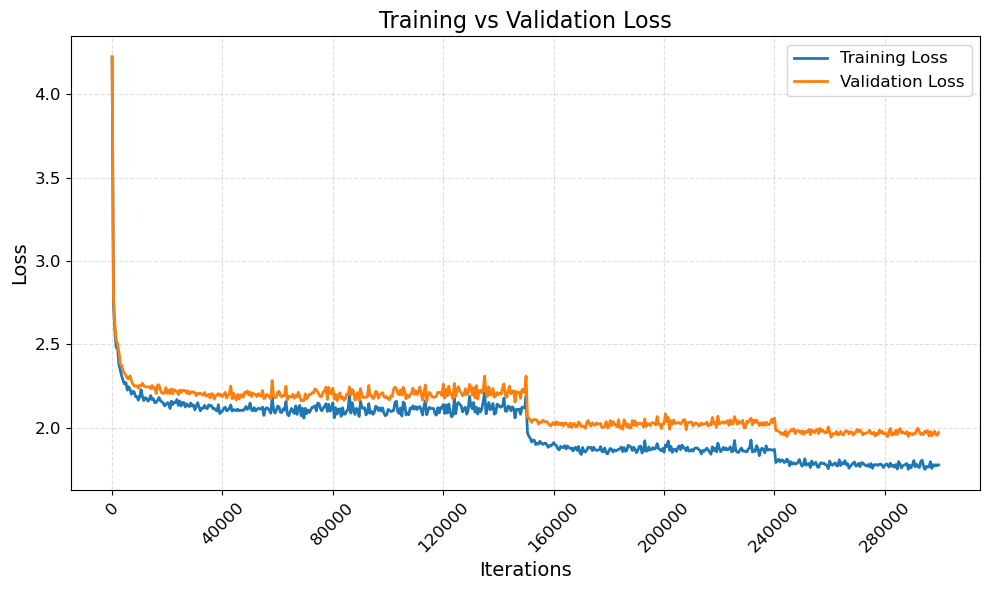

Train loss : 1.7700
Dev loss : 1.9700
train loss (without regularization loss): 1.6453
dev loss (without regularization loss): 1.8454
-----------------------------------------
MODEL 8:
      0/ 300000: 4.3976
  10000/ 300000: 2.1498
  20000/ 300000: 2.2786
  30000/ 300000: 2.2046
  40000/ 300000: 2.1303
  50000/ 300000: 2.2698
  60000/ 300000: 2.0522
  70000/ 300000: 2.1875
  80000/ 300000: 2.0946
  90000/ 300000: 1.9632
 100000/ 300000: 1.9954
 110000/ 300000: 1.8297
 120000/ 300000: 1.8828
 130000/ 300000: 2.0086
 140000/ 300000: 1.9136
 150000/ 300000: 2.1689
 160000/ 300000: 2.0282
 170000/ 300000: 1.9380
 180000/ 300000: 1.8845
 190000/ 300000: 1.9212
 200000/ 300000: 1.7450
 210000/ 300000: 1.7597
 220000/ 300000: 1.6938
 230000/ 300000: 1.6824
 240000/ 300000: 1.7816
 250000/ 300000: 1.5365
 260000/ 300000: 1.6184
 270000/ 300000: 1.6548
 280000/ 300000: 2.0182
 290000/ 300000: 1.7565


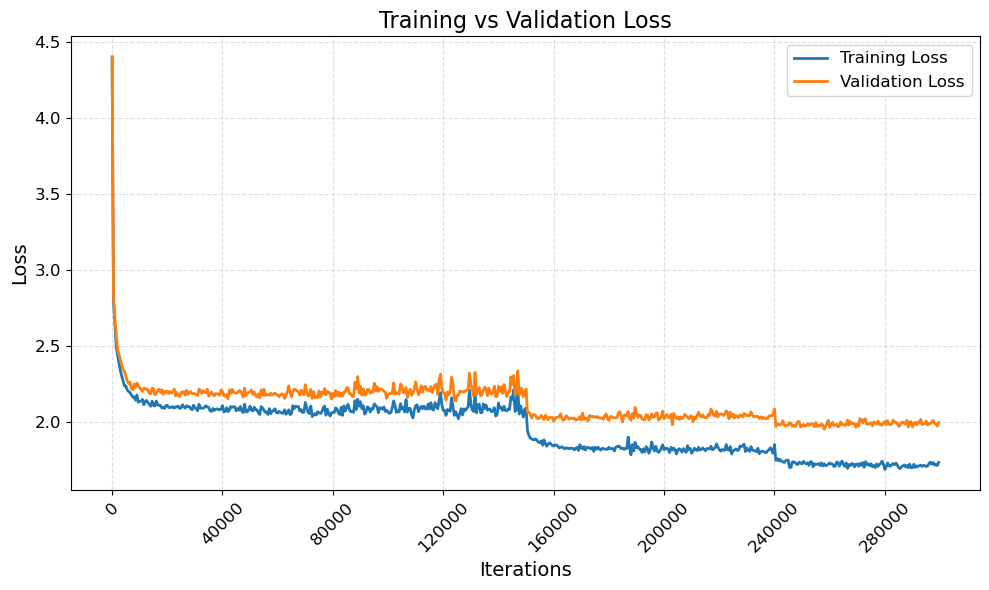

Train loss : 1.7132
Dev loss : 1.9941
train loss (without regularization loss): 1.5497
dev loss (without regularization loss): 1.8306
-----------------------------------------
MODEL 9:
      0/ 300000: 3.8926
  10000/ 300000: 1.9015
  20000/ 300000: 2.2263
  30000/ 300000: 1.9260
  40000/ 300000: 1.8642
  50000/ 300000: 2.0195
  60000/ 300000: 2.1880
  70000/ 300000: 1.9482
  80000/ 300000: 1.9025
  90000/ 300000: 2.0737
 100000/ 300000: 2.0167
 110000/ 300000: 1.9458
 120000/ 300000: 2.2887
 130000/ 300000: 2.0823
 140000/ 300000: 2.0665
 150000/ 300000: 1.8933
 160000/ 300000: 1.9981
 170000/ 300000: 2.0516
 180000/ 300000: 1.9794
 190000/ 300000: 2.0590
 200000/ 300000: 1.8555
 210000/ 300000: 1.9768
 220000/ 300000: 1.8546
 230000/ 300000: 1.8611
 240000/ 300000: 1.7766
 250000/ 300000: 2.1719
 260000/ 300000: 1.9462
 270000/ 300000: 1.8479
 280000/ 300000: 1.9883
 290000/ 300000: 1.5202


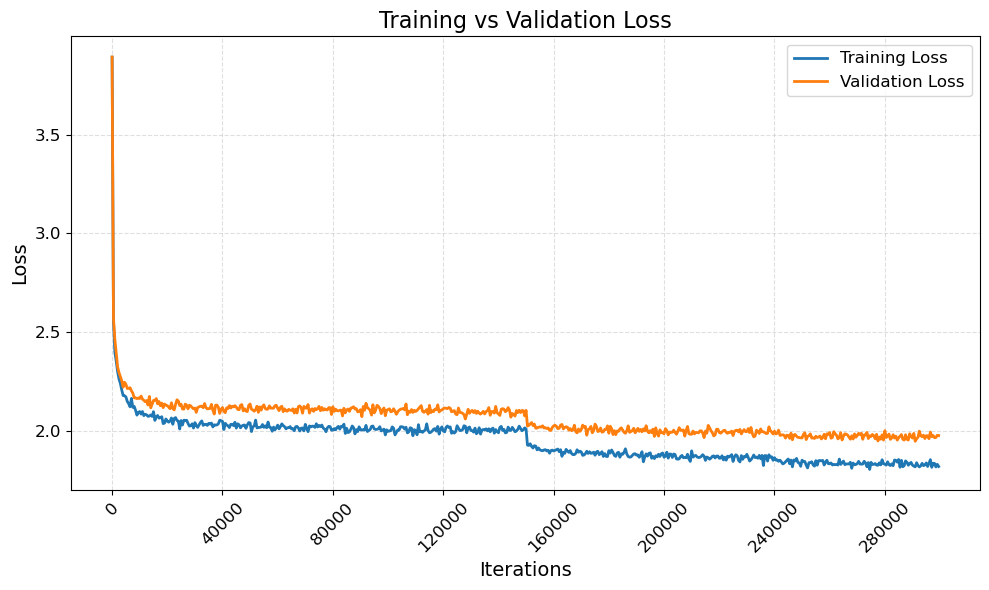

Train loss : 1.8316
Dev loss : 1.9717
train loss (without regularization loss): 1.7483
dev loss (without regularization loss): 1.8883
-----------------------------------------
MODEL 11:
      0/ 300000: 3.9066
  10000/ 300000: 2.1785
  20000/ 300000: 2.2436
  30000/ 300000: 1.9652
  40000/ 300000: 2.0268
  50000/ 300000: 2.0926
  60000/ 300000: 1.7452
  70000/ 300000: 1.9295
  80000/ 300000: 1.8561
  90000/ 300000: 2.0142
 100000/ 300000: 2.1169
 110000/ 300000: 1.8738
 120000/ 300000: 2.2164
 130000/ 300000: 1.9466
 140000/ 300000: 2.1265
 150000/ 300000: 1.8944
 160000/ 300000: 1.9922
 170000/ 300000: 1.7836
 180000/ 300000: 2.0651
 190000/ 300000: 1.9932
 200000/ 300000: 1.9451
 210000/ 300000: 1.9819
 220000/ 300000: 1.9670
 230000/ 300000: 1.9067
 240000/ 300000: 1.8086
 250000/ 300000: 1.9161
 260000/ 300000: 1.7037
 270000/ 300000: 1.7697
 280000/ 300000: 1.8328
 290000/ 300000: 1.9962


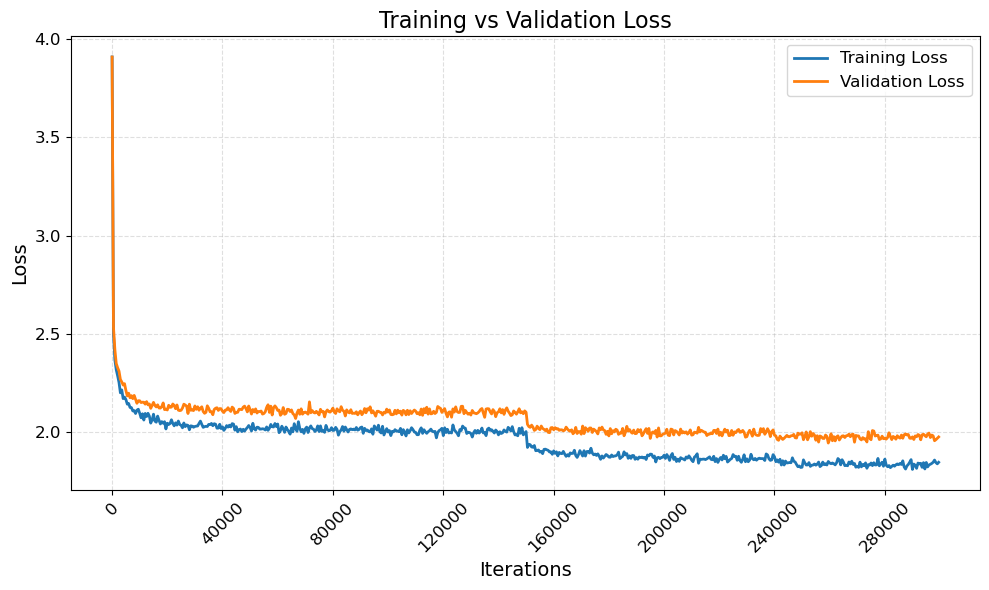

Train loss : 1.8334
Dev loss : 1.9765
train loss (without regularization loss): 1.7442
dev loss (without regularization loss): 1.8873
-----------------------------------------
MODEL 12:
      0/ 300000: 4.0987
  10000/ 300000: 2.0357
  20000/ 300000: 2.1135
  30000/ 300000: 2.3630
  40000/ 300000: 2.1292
  50000/ 300000: 2.1274
  60000/ 300000: 2.0165
  70000/ 300000: 2.2226
  80000/ 300000: 2.0998
  90000/ 300000: 2.2188
 100000/ 300000: 2.0948
 110000/ 300000: 2.1975
 120000/ 300000: 2.0246
 130000/ 300000: 2.2178
 140000/ 300000: 2.3249
 150000/ 300000: 1.9387
 160000/ 300000: 1.9909
 170000/ 300000: 1.9730
 180000/ 300000: 2.1895
 190000/ 300000: 1.9232
 200000/ 300000: 1.9585
 210000/ 300000: 2.0034
 220000/ 300000: 1.9484
 230000/ 300000: 1.9905
 240000/ 300000: 1.9126
 250000/ 300000: 1.9139
 260000/ 300000: 2.0357
 270000/ 300000: 1.8435
 280000/ 300000: 1.8684
 290000/ 300000: 1.7397


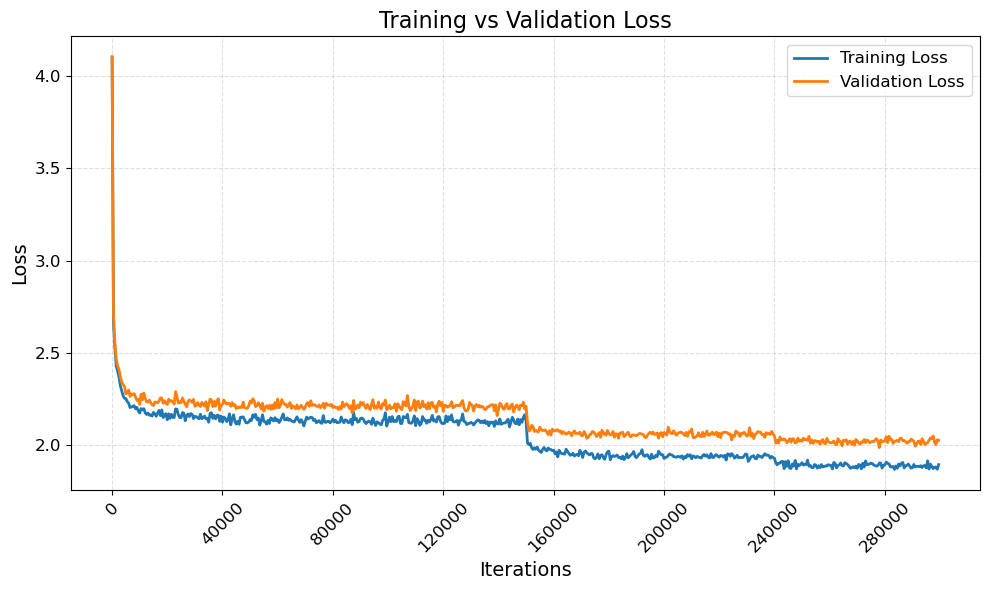

Train loss : 1.8832
Dev loss : 2.0232
train loss (without regularization loss): 1.7452
dev loss (without regularization loss): 1.8853
-----------------------------------------
MODEL 13:
      0/ 300000: 4.2399
  10000/ 300000: 2.4883
  20000/ 300000: 1.9931
  30000/ 300000: 2.0805
  40000/ 300000: 2.2266
  50000/ 300000: 1.8413
  60000/ 300000: 2.0147
  70000/ 300000: 2.2063
  80000/ 300000: 2.1949
  90000/ 300000: 2.0044
 100000/ 300000: 2.0166
 110000/ 300000: 2.0602
 120000/ 300000: 1.9893
 130000/ 300000: 2.2143
 140000/ 300000: 1.9836
 150000/ 300000: 2.1060
 160000/ 300000: 2.0144
 170000/ 300000: 1.9480
 180000/ 300000: 1.8351
 190000/ 300000: 1.8107
 200000/ 300000: 1.9104
 210000/ 300000: 1.9300
 220000/ 300000: 1.9722
 230000/ 300000: 2.0958
 240000/ 300000: 1.7744
 250000/ 300000: 1.9377
 260000/ 300000: 2.0542
 270000/ 300000: 1.7405
 280000/ 300000: 1.8902
 290000/ 300000: 1.9689


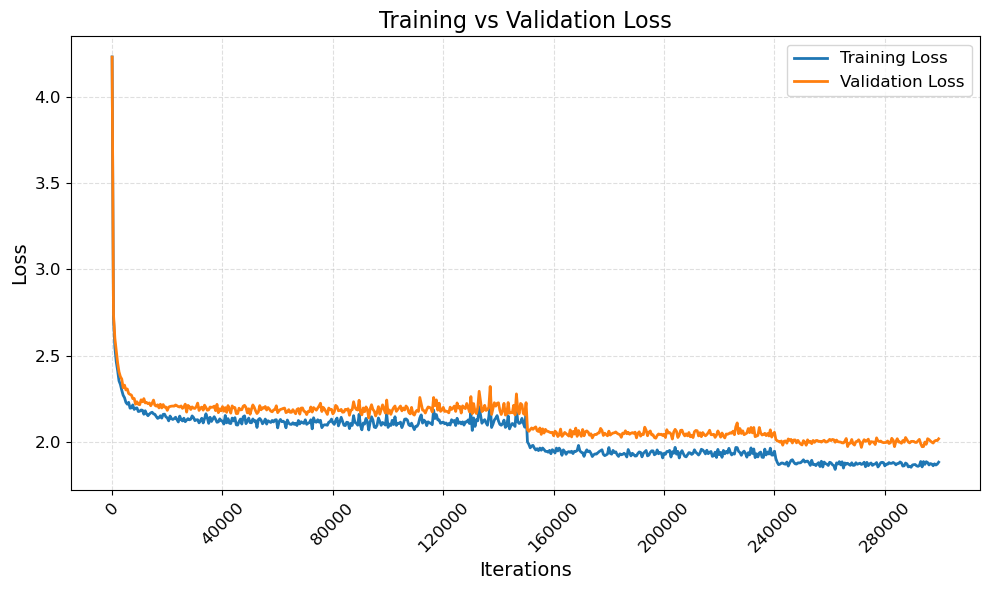

Train loss : 1.8688
Dev loss : 2.0004
train loss (without regularization loss): 1.7550
dev loss (without regularization loss): 1.8865
-----------------------------------------


In [23]:
models = [model1, model2, model3, model4, model5, model6, model7, model8, model9, model11, model12, model13]
i = [1, 2, 3, 4, 5, 6, 7 ,8 ,9, 11, 12, 13]
wds = [2e-4, 1.5e-4, 2e-4, 0.8e-4, 1.2e-4, 3.5e-4, 5e-4, 7e-4, 2e-4, 1.5e-4, 3.5e-4, 4e-4]
for model, ind in zip(models, i, wds):
    if ind in [6, 7, 8, 12, 13]:
        wd = 3e-4
    else:
        wd = 1e-4
    print(f'MODEL {ind}:')
    train_and_eval(model, max_steps, batch_size, lr, wd=wd)
    print('-----------------------------------------')

In [24]:
models = [model1, model2, model3, model4, model5, model6, model7, model8, model9, model11, model12, model13]
i = [1, 2, 3, 4, 5, 6, 7 ,8 ,9, 11, 12, 13]

for model, ind in zip(models, i):
    print(f'MODEL {ind}:')
    model.no_reg_loss('train')
    model.no_reg_loss('dev')
    print('-----------------------------------------')


MODEL 1:
train loss (without regularization loss): 1.7745
dev loss (without regularization loss): 1.9046
-----------------------------------------
MODEL 2:
train loss (without regularization loss): 1.7520
dev loss (without regularization loss): 1.8902
-----------------------------------------
MODEL 3:
train loss (without regularization loss): 1.7395
dev loss (without regularization loss): 1.8863
-----------------------------------------
MODEL 4:
train loss (without regularization loss): 2.0130
dev loss (without regularization loss): 2.0730
-----------------------------------------
MODEL 5:
train loss (without regularization loss): 1.8043
dev loss (without regularization loss): 1.9146
-----------------------------------------
MODEL 6:
train loss (without regularization loss): 1.7388
dev loss (without regularization loss): 1.8720
-----------------------------------------
MODEL 7:
train loss (without regularization loss): 1.6453
dev loss (without regularization loss): 1.8454
-------------

MODEL 1:
      0/ 300000: 3.9413
  10000/ 300000: 2.1267
  20000/ 300000: 2.1196
  30000/ 300000: 2.0070
  40000/ 300000: 2.0172
  50000/ 300000: 2.2350
  60000/ 300000: 2.1554
  70000/ 300000: 2.0294
  80000/ 300000: 2.0906
  90000/ 300000: 2.0767
 100000/ 300000: 1.9456
 110000/ 300000: 2.0281
 120000/ 300000: 2.1426
 130000/ 300000: 2.0757
 140000/ 300000: 1.9655
 150000/ 300000: 2.0729
 160000/ 300000: 1.9269
 170000/ 300000: 1.9085
 180000/ 300000: 1.9162
 190000/ 300000: 1.9139
 200000/ 300000: 1.8967
 210000/ 300000: 1.9181
 220000/ 300000: 1.9671
 230000/ 300000: 1.9134
 240000/ 300000: 1.9831
 250000/ 300000: 1.7975
 260000/ 300000: 1.7269
 270000/ 300000: 1.8598
 280000/ 300000: 1.9520
 290000/ 300000: 1.9414


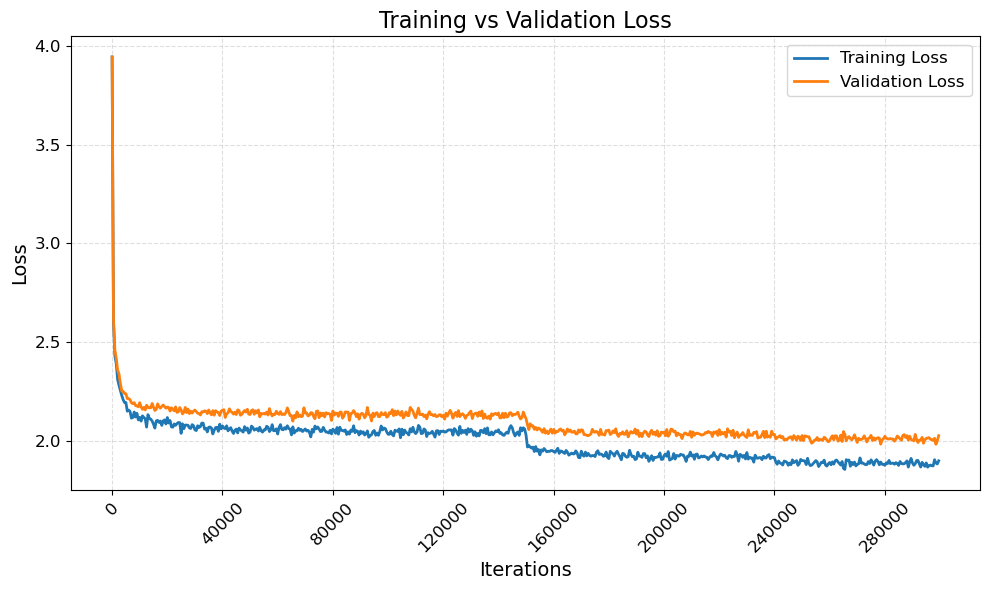

Train loss : 1.8833
Dev loss : 2.0062
train loss (without regularization loss): 1.7801
dev loss (without regularization loss): 1.9030
-----------------------------------------
MODEL 2:
      0/ 300000: 3.9282
  10000/ 300000: 2.0136
  20000/ 300000: 2.0995
  30000/ 300000: 2.0245
  40000/ 300000: 1.9011
  50000/ 300000: 1.9763
  60000/ 300000: 1.9302
  70000/ 300000: 1.9184
  80000/ 300000: 2.0217
  90000/ 300000: 1.9322
 100000/ 300000: 1.9460
 110000/ 300000: 1.9463
 120000/ 300000: 1.8341
 130000/ 300000: 1.8856
 140000/ 300000: 1.9676
 150000/ 300000: 1.8592
 160000/ 300000: 1.8577
 170000/ 300000: 1.9478
 180000/ 300000: 1.9308
 190000/ 300000: 1.8251
 200000/ 300000: 1.9081
 210000/ 300000: 1.7851
 220000/ 300000: 1.7190
 230000/ 300000: 1.8444
 240000/ 300000: 1.8920
 250000/ 300000: 1.8412
 260000/ 300000: 1.9422
 270000/ 300000: 1.8561
 280000/ 300000: 1.8616
 290000/ 300000: 1.9898


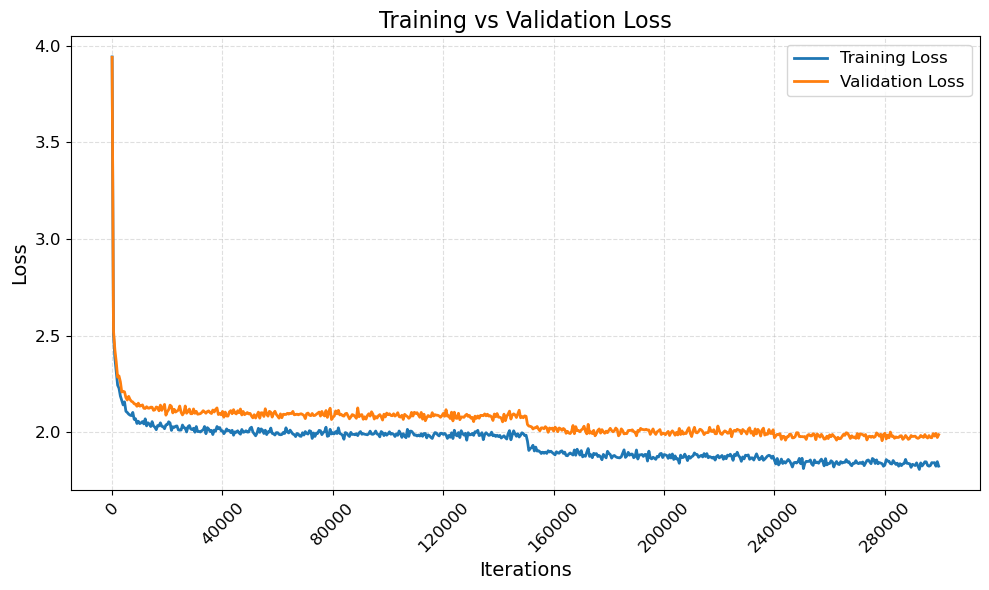

Train loss : 1.8394
Dev loss : 1.9794
train loss (without regularization loss): 1.7476
dev loss (without regularization loss): 1.8877
-----------------------------------------
MODEL 3:
      0/ 300000: 4.0223
  10000/ 300000: 2.0842
  20000/ 300000: 2.0944
  30000/ 300000: 2.0791
  40000/ 300000: 2.0818
  50000/ 300000: 2.0804
  60000/ 300000: 1.9910
  70000/ 300000: 2.0222
  80000/ 300000: 2.0302
  90000/ 300000: 2.0499
 100000/ 300000: 1.9942
 110000/ 300000: 1.9941
 120000/ 300000: 1.8819
 130000/ 300000: 2.1026
 140000/ 300000: 2.0379
 150000/ 300000: 1.9445
 160000/ 300000: 1.8964
 170000/ 300000: 1.9028
 180000/ 300000: 1.9882
 190000/ 300000: 2.0007
 200000/ 300000: 1.9535
 210000/ 300000: 1.8350
 220000/ 300000: 1.8985
 230000/ 300000: 1.8582
 240000/ 300000: 1.9386
 250000/ 300000: 1.7451
 260000/ 300000: 1.7337
 270000/ 300000: 1.6880
 280000/ 300000: 1.8697
 290000/ 300000: 1.7979


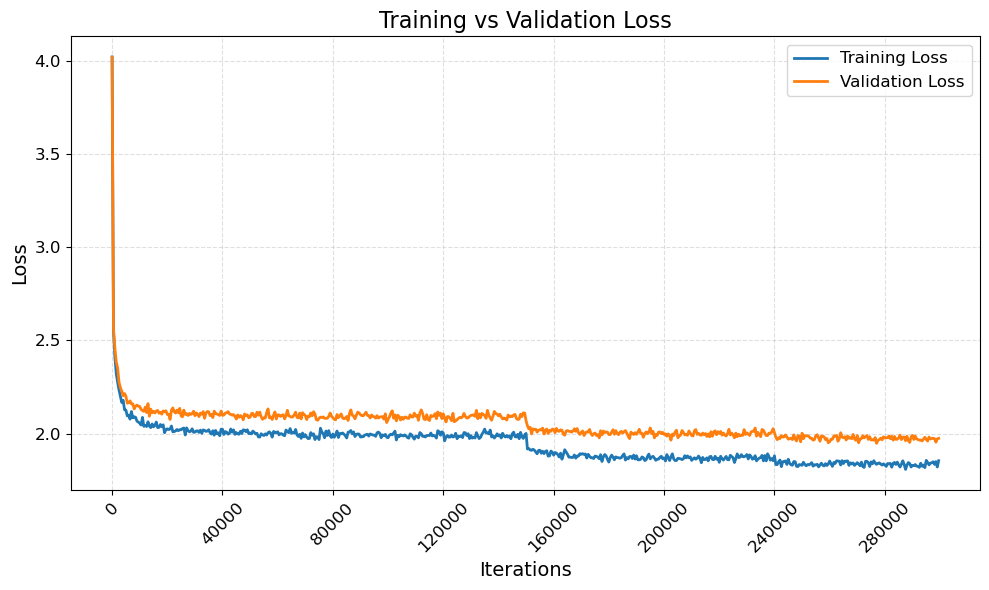

Train loss : 1.8332
Dev loss : 1.9767
train loss (without regularization loss): 1.7354
dev loss (without regularization loss): 1.8789
-----------------------------------------
MODEL 4:
      0/ 300000: 3.8456
  10000/ 300000: 2.1641
  20000/ 300000: 2.2342
  30000/ 300000: 2.0984
  40000/ 300000: 2.1917
  50000/ 300000: 2.2583
  60000/ 300000: 2.0105
  70000/ 300000: 2.0183
  80000/ 300000: 2.1787
  90000/ 300000: 2.0703
 100000/ 300000: 2.1858
 110000/ 300000: 2.0751
 120000/ 300000: 2.0521
 130000/ 300000: 2.1189
 140000/ 300000: 2.1762
 150000/ 300000: 2.0977
 160000/ 300000: 2.1592
 170000/ 300000: 1.9778
 180000/ 300000: 2.0414
 190000/ 300000: 2.1179
 200000/ 300000: 2.0115
 210000/ 300000: 1.9298
 220000/ 300000: 2.0114
 230000/ 300000: 2.2484
 240000/ 300000: 2.1341
 250000/ 300000: 2.1190
 260000/ 300000: 2.1687
 270000/ 300000: 2.0408
 280000/ 300000: 2.1023
 290000/ 300000: 2.0128


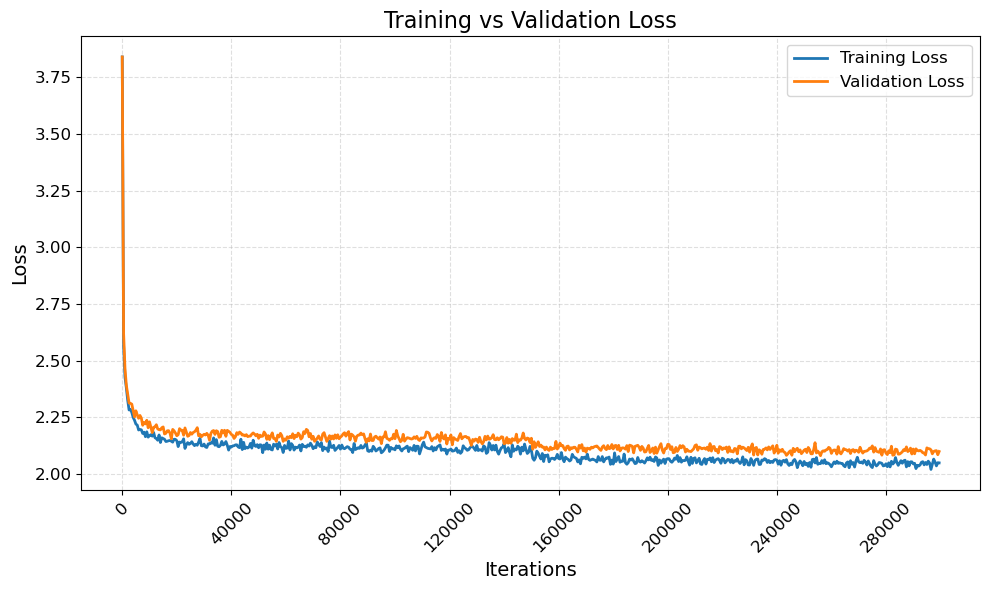

Train loss : 2.0459
Dev loss : 2.1011
train loss (without regularization loss): 2.0013
dev loss (without regularization loss): 2.0566
-----------------------------------------
MODEL 5:
      0/ 300000: 3.9022
  10000/ 300000: 2.0228
  20000/ 300000: 1.9486
  30000/ 300000: 2.0668
  40000/ 300000: 1.8993
  50000/ 300000: 1.9283
  60000/ 300000: 1.8235
  70000/ 300000: 2.1136
  80000/ 300000: 1.9281
  90000/ 300000: 2.1545
 100000/ 300000: 2.0117
 110000/ 300000: 1.9141
 120000/ 300000: 1.8956
 130000/ 300000: 2.0006
 140000/ 300000: 1.9447
 150000/ 300000: 2.0836
 160000/ 300000: 1.9857
 170000/ 300000: 1.6503
 180000/ 300000: 1.8831
 190000/ 300000: 1.7332
 200000/ 300000: 1.9155
 210000/ 300000: 1.9287
 220000/ 300000: 2.0030
 230000/ 300000: 1.9197
 240000/ 300000: 1.8699
 250000/ 300000: 1.9382
 260000/ 300000: 1.8961
 270000/ 300000: 1.8050
 280000/ 300000: 1.8837
 290000/ 300000: 1.8556


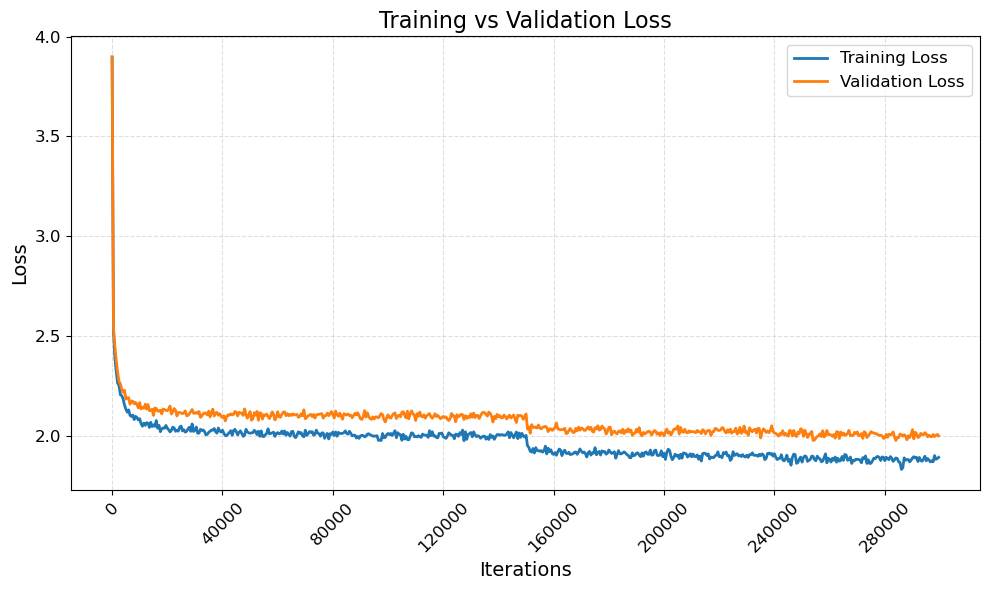

Train loss : 1.8797
Dev loss : 2.0044
train loss (without regularization loss): 1.7933
dev loss (without regularization loss): 1.9180
-----------------------------------------
MODEL 6:
      0/ 300000: 4.2202
  10000/ 300000: 2.0555
  20000/ 300000: 1.9643
  30000/ 300000: 2.1330
  40000/ 300000: 2.0092
  50000/ 300000: 2.0269
  60000/ 300000: 2.1052
  70000/ 300000: 2.0145
  80000/ 300000: 2.0916
  90000/ 300000: 2.0520
 100000/ 300000: 2.2055
 110000/ 300000: 1.9673
 120000/ 300000: 2.0040
 130000/ 300000: 2.0020
 140000/ 300000: 1.9888
 150000/ 300000: 2.0273
 160000/ 300000: 2.0030
 170000/ 300000: 1.9060
 180000/ 300000: 1.9553
 190000/ 300000: 1.8630
 200000/ 300000: 1.9537
 210000/ 300000: 1.7235
 220000/ 300000: 2.0365
 230000/ 300000: 2.0271
 240000/ 300000: 1.8509
 250000/ 300000: 1.8165
 260000/ 300000: 1.9037
 270000/ 300000: 1.9031
 280000/ 300000: 1.8234
 290000/ 300000: 1.8145


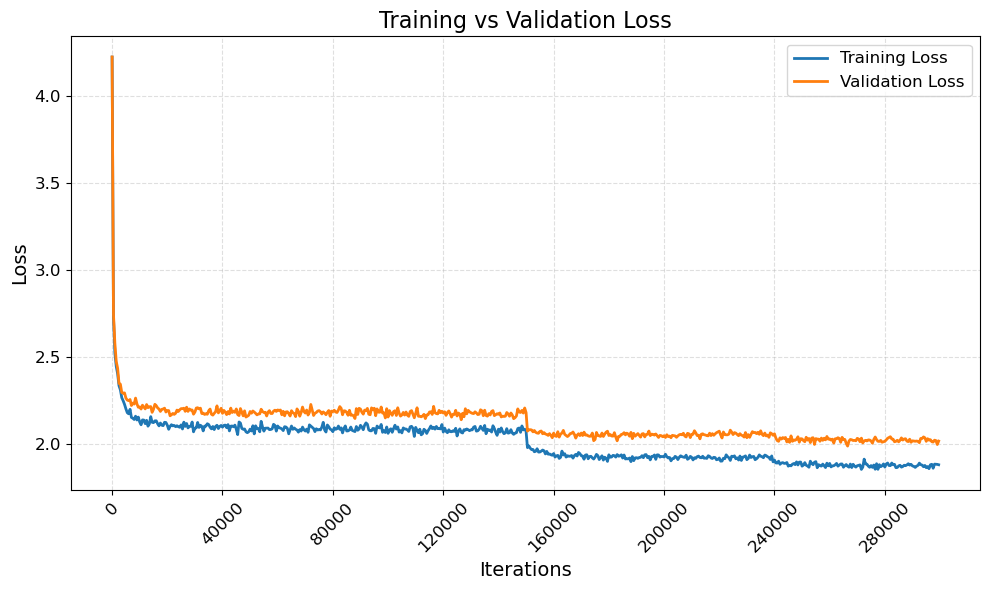

Train loss : 1.8713
Dev loss : 2.0208
train loss (without regularization loss): 1.7165
dev loss (without regularization loss): 1.8660
-----------------------------------------
MODEL 7:
      0/ 300000: 4.5051
  10000/ 300000: 2.2611
  20000/ 300000: 2.2003
  30000/ 300000: 2.2599
  40000/ 300000: 2.1921
  50000/ 300000: 1.9910
  60000/ 300000: 2.1346
  70000/ 300000: 2.0693
  80000/ 300000: 2.0571
  90000/ 300000: 2.1048
 100000/ 300000: 2.0206
 110000/ 300000: 2.0575
 120000/ 300000: 2.0187
 130000/ 300000: 2.2359
 140000/ 300000: 1.9695
 150000/ 300000: 1.9773
 160000/ 300000: 1.9734
 170000/ 300000: 1.9774
 180000/ 300000: 1.8159
 190000/ 300000: 1.7343
 200000/ 300000: 1.9300
 210000/ 300000: 1.9351
 220000/ 300000: 1.9857
 230000/ 300000: 2.0745
 240000/ 300000: 1.8151
 250000/ 300000: 1.8212
 260000/ 300000: 1.9315
 270000/ 300000: 1.8938
 280000/ 300000: 1.7755
 290000/ 300000: 1.7959


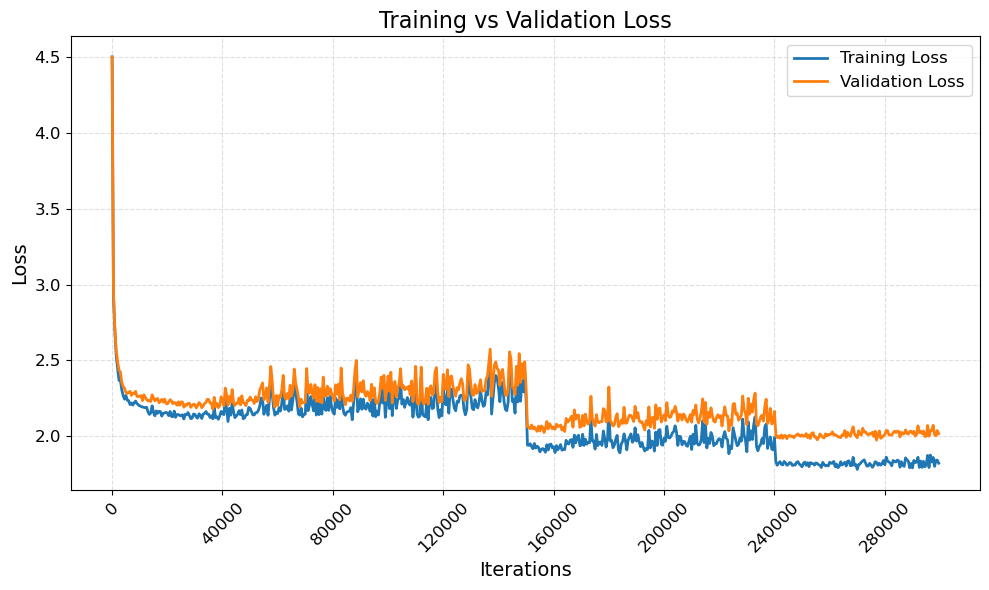

Train loss : 1.8357
Dev loss : 2.0317
train loss (without regularization loss): 1.7008
dev loss (without regularization loss): 1.8967
-----------------------------------------
MODEL 8:
      0/ 300000: 5.2069
  10000/ 300000: 2.2339
  20000/ 300000: 2.2435
  30000/ 300000: 2.1502
  40000/ 300000: 1.9367
  50000/ 300000: 2.0573
  60000/ 300000: 2.0309
  70000/ 300000: 2.0438
  80000/ 300000: 2.1297
  90000/ 300000: 2.0639
 100000/ 300000: 2.0438
 110000/ 300000: 2.0607
 120000/ 300000: 2.2660
 130000/ 300000: 2.0355
 140000/ 300000: 2.1178
 150000/ 300000: 2.0772
 160000/ 300000: 1.8211
 170000/ 300000: 1.8411
 180000/ 300000: 1.8917
 190000/ 300000: 1.7993
 200000/ 300000: 1.8759
 210000/ 300000: 1.8235
 220000/ 300000: 1.7195
 230000/ 300000: 1.8010
 240000/ 300000: 1.9201
 250000/ 300000: 1.7341
 260000/ 300000: 1.8081
 270000/ 300000: 1.5593
 280000/ 300000: 1.8052
 290000/ 300000: 1.8093


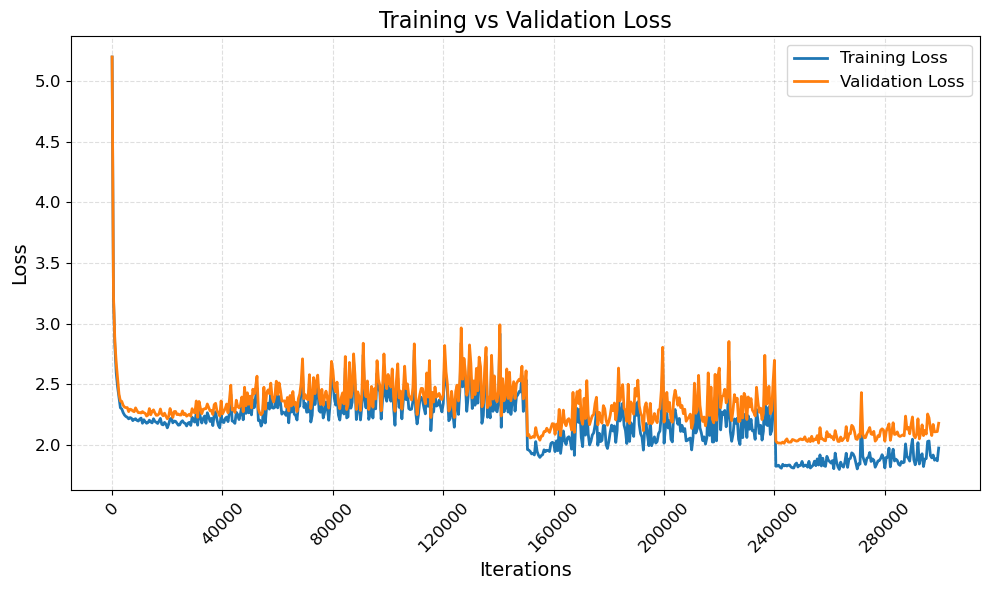

Train loss : 1.8977
Dev loss : 2.1170
train loss (without regularization loss): 1.7376
dev loss (without regularization loss): 1.9569
-----------------------------------------
MODEL 9:
      0/ 300000: 4.0053
  10000/ 300000: 2.0083
  20000/ 300000: 1.9531
  30000/ 300000: 2.1304
  40000/ 300000: 1.9543
  50000/ 300000: 2.1007
  60000/ 300000: 2.0392
  70000/ 300000: 2.0512
  80000/ 300000: 1.9327
  90000/ 300000: 2.0056
 100000/ 300000: 2.0755
 110000/ 300000: 2.2005
 120000/ 300000: 2.1523
 130000/ 300000: 2.0501
 140000/ 300000: 1.9213
 150000/ 300000: 2.1046
 160000/ 300000: 1.8852
 170000/ 300000: 1.8121
 180000/ 300000: 1.8851
 190000/ 300000: 1.9499
 200000/ 300000: 1.9069
 210000/ 300000: 1.8801
 220000/ 300000: 1.7464
 230000/ 300000: 1.9827
 240000/ 300000: 2.0185
 250000/ 300000: 1.9136
 260000/ 300000: 1.9029
 270000/ 300000: 1.8582
 280000/ 300000: 1.7941
 290000/ 300000: 1.8471


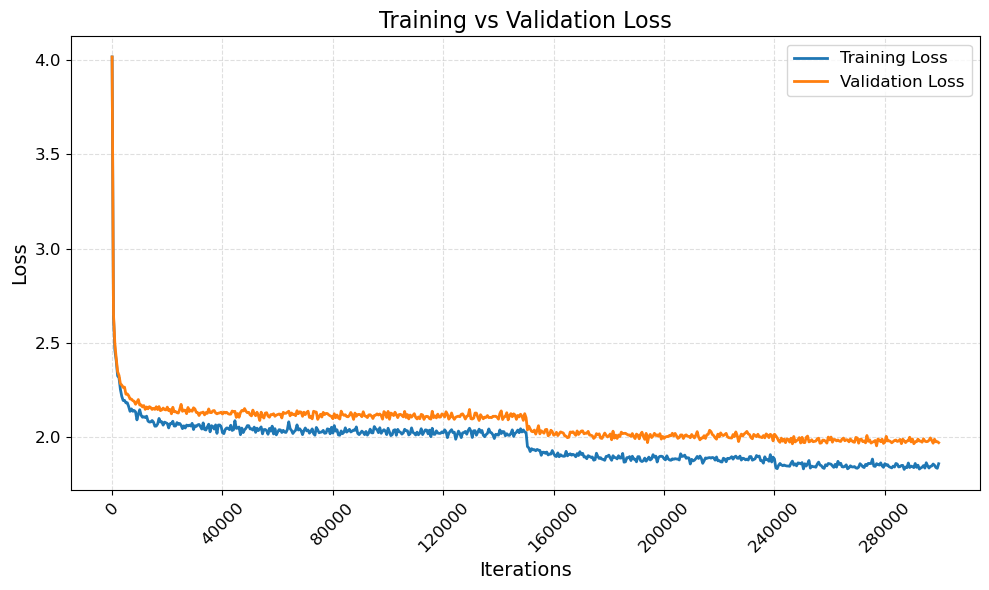

Train loss : 1.8465
Dev loss : 1.9807
train loss (without regularization loss): 1.7474
dev loss (without regularization loss): 1.8816
-----------------------------------------
MODEL 11:
      0/ 300000: 3.9622
  10000/ 300000: 2.0993
  20000/ 300000: 2.0582
  30000/ 300000: 2.1341
  40000/ 300000: 1.9565
  50000/ 300000: 1.9423
  60000/ 300000: 2.0333
  70000/ 300000: 1.9824
  80000/ 300000: 1.9325
  90000/ 300000: 2.1223
 100000/ 300000: 1.9113
 110000/ 300000: 1.8784
 120000/ 300000: 1.9399
 130000/ 300000: 1.9939
 140000/ 300000: 1.8113
 150000/ 300000: 2.0140
 160000/ 300000: 1.8264
 170000/ 300000: 1.8750
 180000/ 300000: 1.7348
 190000/ 300000: 1.8396
 200000/ 300000: 1.9113
 210000/ 300000: 1.8738
 220000/ 300000: 1.7905
 230000/ 300000: 2.0586
 240000/ 300000: 1.8328
 250000/ 300000: 1.6755
 260000/ 300000: 1.9985
 270000/ 300000: 1.7374
 280000/ 300000: 1.8686
 290000/ 300000: 1.7154


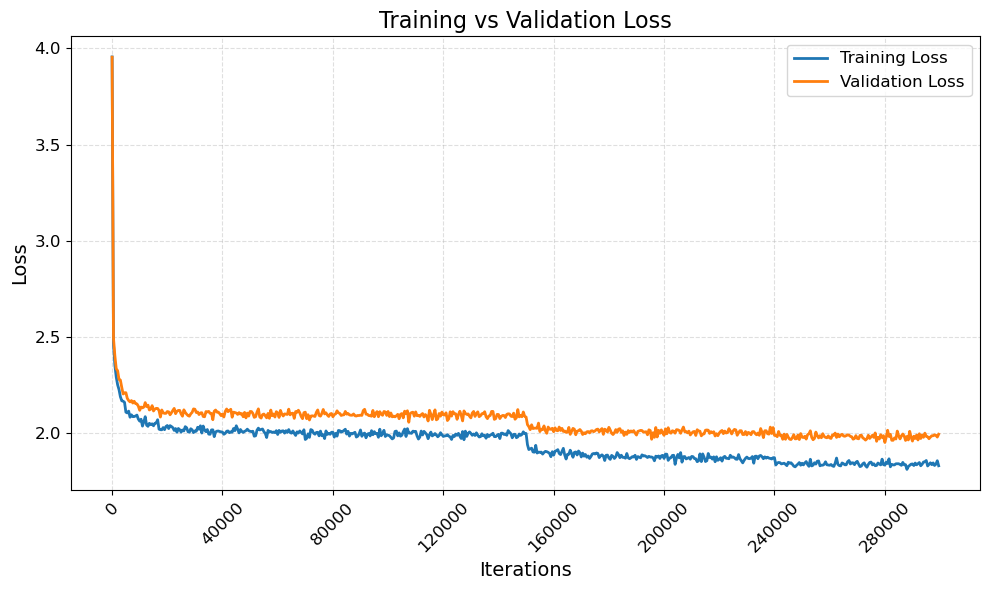

Train loss : 1.8364
Dev loss : 1.9820
train loss (without regularization loss): 1.7362
dev loss (without regularization loss): 1.8819
-----------------------------------------
MODEL 12:
      0/ 300000: 4.1695
  10000/ 300000: 2.2848
  20000/ 300000: 2.1098
  30000/ 300000: 2.0480
  40000/ 300000: 2.0820
  50000/ 300000: 2.2525
  60000/ 300000: 2.0919
  70000/ 300000: 2.0373
  80000/ 300000: 2.0320
  90000/ 300000: 2.0671
 100000/ 300000: 2.1656
 110000/ 300000: 2.2147
 120000/ 300000: 2.1149
 130000/ 300000: 1.9875
 140000/ 300000: 2.0637
 150000/ 300000: 2.1215
 160000/ 300000: 2.0616
 170000/ 300000: 1.9127
 180000/ 300000: 1.8048
 190000/ 300000: 1.9141
 200000/ 300000: 2.0224
 210000/ 300000: 2.0451
 220000/ 300000: 1.9428
 230000/ 300000: 1.8800
 240000/ 300000: 2.0248
 250000/ 300000: 2.0577
 260000/ 300000: 1.8315
 270000/ 300000: 1.8548
 280000/ 300000: 1.7955
 290000/ 300000: 1.7240


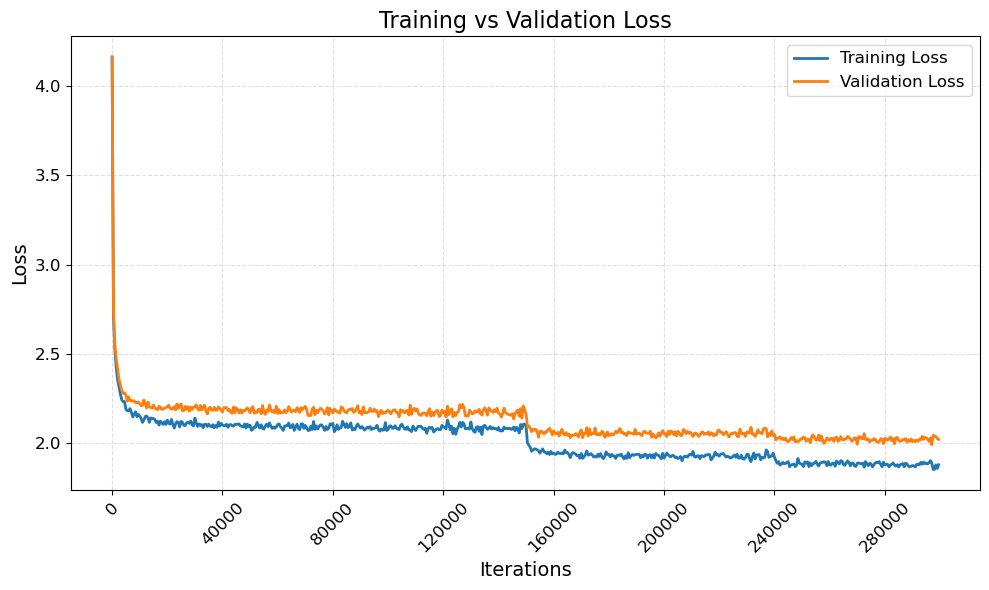

Train loss : 1.8791
Dev loss : 2.0236
train loss (without regularization loss): 1.7318
dev loss (without regularization loss): 1.8764
-----------------------------------------
MODEL 13:
      0/ 300000: 4.4146
  10000/ 300000: 2.1438
  20000/ 300000: 2.2082
  30000/ 300000: 2.1410
  40000/ 300000: 2.1235
  50000/ 300000: 2.1631
  60000/ 300000: 2.0936
  70000/ 300000: 1.9770
  80000/ 300000: 2.0801
  90000/ 300000: 1.9679
 100000/ 300000: 2.0284
 110000/ 300000: 1.9486
 120000/ 300000: 2.0606
 130000/ 300000: 2.0615
 140000/ 300000: 2.0371
 150000/ 300000: 2.0563
 160000/ 300000: 1.8557
 170000/ 300000: 2.0169
 180000/ 300000: 1.9821
 190000/ 300000: 2.0424
 200000/ 300000: 1.7870
 210000/ 300000: 1.9392
 220000/ 300000: 2.0609
 230000/ 300000: 1.8353
 240000/ 300000: 1.9337
 250000/ 300000: 1.7219
 260000/ 300000: 1.9949
 270000/ 300000: 1.8482
 280000/ 300000: 1.9809
 290000/ 300000: 1.8779


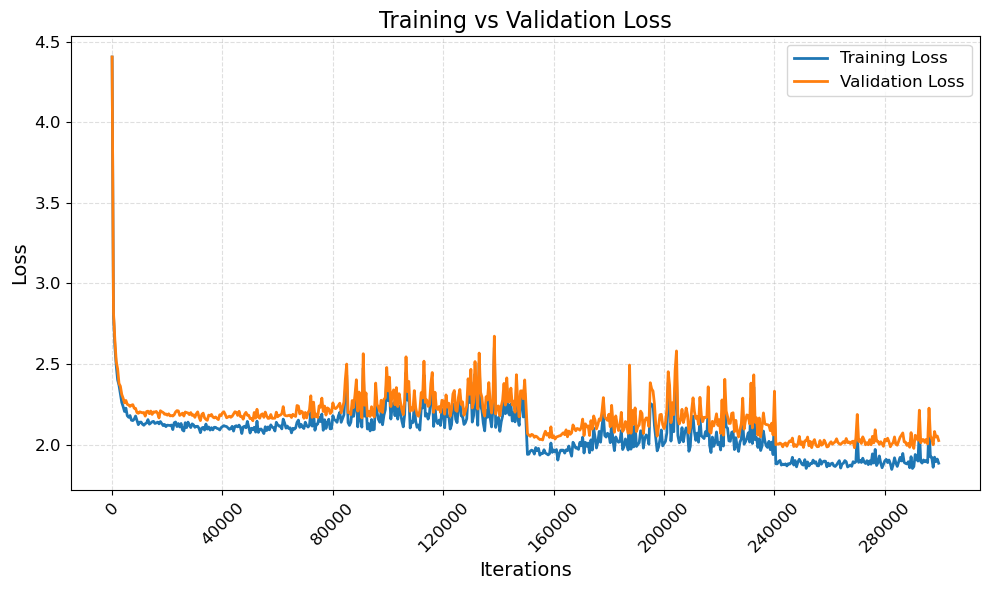

Train loss : 1.8896
Dev loss : 2.0131
train loss (without regularization loss): 1.7710
dev loss (without regularization loss): 1.8945
-----------------------------------------


In [38]:
models = [model1, model2, model3, model4, model5, model6, model7, model8, model9, model11, model12, model13]
i = [1, 2, 3, 4, 5, 6, 7 ,8 ,9, 11, 12, 13]
wds = [2e-4, 1.5e-4, 2e-4, 0.8e-4, 1.2e-4, 3.5e-4, 5e-4, 7e-4, 2e-4, 1.5e-4, 3.5e-4, 4e-4]
for model, ind, wd in zip(models, i, wds):
    print(f'MODEL {ind}:')
    train_and_eval(model, max_steps, batch_size, lr, wd=wd)
    print('-----------------------------------------')

In [39]:
models = [model1, model2, model3, model4, model5, model6, model7, model8, model9, model11, model12, model13]
i = [1, 2, 3, 4, 5, 6, 7 ,8 ,9, 11, 12, 13]

for model, ind in zip(models, i):
    print(f'MODEL {ind}:')
    model.no_reg_loss('train')
    model.no_reg_loss('dev')
    print('-----------------------------------------')
 

MODEL 1:
train loss (without regularization loss): 1.7801
dev loss (without regularization loss): 1.9030
-----------------------------------------
MODEL 2:
train loss (without regularization loss): 1.7476
dev loss (without regularization loss): 1.8877
-----------------------------------------
MODEL 3:
train loss (without regularization loss): 1.7354
dev loss (without regularization loss): 1.8789
-----------------------------------------
MODEL 4:
train loss (without regularization loss): 2.0013
dev loss (without regularization loss): 2.0566
-----------------------------------------
MODEL 5:
train loss (without regularization loss): 1.7933
dev loss (without regularization loss): 1.9180
-----------------------------------------
MODEL 6:
train loss (without regularization loss): 1.7165
dev loss (without regularization loss): 1.8660
-----------------------------------------
MODEL 7:
train loss (without regularization loss): 1.7008
dev loss (without regularization loss): 1.8967
-------------

## Performance on test set and geterating names

For our final model we will choose model 6 with weight_decay = 3.5e-4. Let's see how it performs on the test set

In [41]:
model6.no_reg_loss('test')

test loss (without regularization loss): 1.8285


In [42]:
model6.generate(20)

corine hills^
bennenton^
faintouldo beach^
pineston^
cocfen-oa village^
nortonville^
culilvire city^
chester^
ounnels^
new cnegue^
stopevin^
lossouk hartin^
stonake^
oregiinan river^
kurriss^
new heights^
hadruca^
vheaturoci^
wyesand hunton^
baxce valley^
